In [ ]:
import os
import wget

In [ ]:
CUSTOM_MODEL_NAME = 'my_ssd_mobnet' 
PRETRAINED_MODEL_NAME = 'ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8'
PRETRAINED_MODEL_URL = 'http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz'
TF_RECORD_SCRIPT_NAME = 'generate_tfrecord.py'
LABEL_MAP_NAME = 'label_map.pbtxt'

paths = {
    'WORKSPACE_PATH': os.path.join('Tensorflow', 'workspace'),
    'SCRIPTS_PATH': os.path.join('Tensorflow','scripts'),
    'APIMODEL_PATH': os.path.join('Tensorflow','models'),
    'ANNOTATION_PATH': os.path.join('Tensorflow', 'workspace','annotations'),
    'IMAGE_PATH': os.path.join('Tensorflow', 'workspace','images'),
    'MODEL_PATH': os.path.join('Tensorflow', 'workspace','models'),
    'PRETRAINED_MODEL_PATH': os.path.join('Tensorflow', 'workspace','pre-trained-models'),
    'CHECKPOINT_PATH': os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME), 
    'OUTPUT_PATH': os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME, 'export'), 
    'TFLITE_PATH':os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME, 'tfliteexport'), 
    'PROTOC_PATH':os.path.join('Tensorflow','protoc')
}

files = {
    'PIPELINE_CONFIG':os.path.join('Tensorflow', 'workspace','models', CUSTOM_MODEL_NAME, 'pipeline.config'),
    'TF_RECORD_SCRIPT': os.path.join(paths['SCRIPTS_PATH'], TF_RECORD_SCRIPT_NAME), 
    'LABELMAP': os.path.join(paths['ANNOTATION_PATH'], LABEL_MAP_NAME)
}

In [ ]:
# Membuat folder untuk tiap path jika belum ada
for path in paths.values():
    if not os.path.exists(path):
        if os.name == 'posix':
            !mkdir -p {path}
        if os.name == 'nt':
            !mkdir {path}

# 1. Download TF Models Pretrained Models from Tensorflow Model Zoo and Install TFOD

In [ ]:
if not os.path.exists(os.path.join(paths['APIMODEL_PATH'], 'research', 'object_detection')):
    !git clone https://github.com/tensorflow/models {paths['APIMODEL_PATH']}

In [ ]:
# Install Tensorflow Object Detection 
if os.name=='posix':  
    !apt-get install protobuf-compiler
    !cd Tensorflow/models/research && protoc object_detection/protos/*.proto --python_out=. && cp object_detection/packages/tf2/setup.py . && python -m pip install . 
    
if os.name=='nt':
    url="https://github.com/protocolbuffers/protobuf/releases/download/v3.15.6/protoc-3.15.6-win64.zip"
    wget.download(url)
    !move protoc-3.15.6-win64.zip {paths['PROTOC_PATH']}
    !cd {paths['PROTOC_PATH']} && tar -xf protoc-3.15.6-win64.zip
    os.environ['PATH'] += os.pathsep + os.path.abspath(os.path.join(paths['PROTOC_PATH'], 'bin'))   
    !cd Tensorflow/models/research && protoc object_detection/protos/*.proto --python_out=. && copy object_detection\\packages\\tf2\\setup.py setup.py && python setup.py build && python setup.py install
    !cd Tensorflow/models/research/slim && pip install -e . 

In [ ]:
VERIFICATION_SCRIPT = os.path.join(paths['APIMODEL_PATH'], 'research', 'object_detection', 'builders', 'model_builder_tf2_test.py')
# Verify Installation
!python {VERIFICATION_SCRIPT}

In [ ]:
import object_detection

In [ ]:
if os.name =='posix':
    !wget {PRETRAINED_MODEL_URL}
    !mv {PRETRAINED_MODEL_NAME+'.tar.gz'} {paths['PRETRAINED_MODEL_PATH']}
    !cd {paths['PRETRAINED_MODEL_PATH']} && tar -zxvf {PRETRAINED_MODEL_NAME+'.tar.gz'}
if os.name == 'nt':
    wget.download(PRETRAINED_MODEL_URL)
    !move {PRETRAINED_MODEL_NAME+'.tar.gz'} {paths['PRETRAINED_MODEL_PATH']}
    !cd {paths['PRETRAINED_MODEL_PATH']} && tar -zxvf {PRETRAINED_MODEL_NAME+'.tar.gz'}

# 2. Create Label Map

In [ ]:
# Manual
# tmp_path = ['botolkaca', 'botolplastik', 'kaleng', 'kardus', 'karet', 'kertas', 'plastik', 'sedotan']
# labels = []

# for id, name in enumerate(tmp_path):
#     labels.append({'name': name, 'id': id+1})
    
# Menggunakan path
COLLECTED_IMG_PATH = r'.\Tensorflow\workspace\images\collectedimages'
labels = []

for id, name in enumerate(os.listdir(COLLECTED_IMG_PATH)):
    labels.append({'name': name, 'id': id+1})

with open(files['LABELMAP'], 'w') as f:
    for label in labels:
        f.write('item { \n')
        f.write('\tname:\'{}\'\n'.format(label['name']))
        f.write('\tid:{}\n'.format(label['id']))
        f.write('}\n')

# 3. Create TF records

In [ ]:
if not os.path.exists(files['TF_RECORD_SCRIPT']):
    !git clone https://github.com/nicknochnack/GenerateTFRecord {paths['SCRIPTS_PATH']}

In [ ]:
!python {files['TF_RECORD_SCRIPT']} -x {os.path.join(paths['IMAGE_PATH'], 'train')} -l {files['LABELMAP']} -o {os.path.join(paths['ANNOTATION_PATH'], 'train.record')} 
!python {files['TF_RECORD_SCRIPT']} -x {os.path.join(paths['IMAGE_PATH'], 'test')} -l {files['LABELMAP']} -o {os.path.join(paths['ANNOTATION_PATH'], 'test.record')} 

# 4. Copy Model Config to Training Folder

In [ ]:
if os.name =='posix':
    !cp {os.path.join(paths['PRETRAINED_MODEL_PATH'], PRETRAINED_MODEL_NAME, 'pipeline.config')} {os.path.join(paths['CHECKPOINT_PATH'])}
if os.name == 'nt':
    !copy {os.path.join(paths['PRETRAINED_MODEL_PATH'], PRETRAINED_MODEL_NAME, 'pipeline.config')} {os.path.join(paths['CHECKPOINT_PATH'])}

# 5. Update Config For Transfer Learning

In [ ]:
import tensorflow as tf
from object_detection.utils import config_util
from object_detection.protos import pipeline_pb2
from google.protobuf import text_format

In [ ]:
config = config_util.get_configs_from_pipeline_file(files['PIPELINE_CONFIG'])
# config

In [ ]:
pipeline_config = pipeline_pb2.TrainEvalPipelineConfig()
with tf.io.gfile.GFile(files['PIPELINE_CONFIG'], "r") as f:                                                                                                                                                                                                                     
    proto_str = f.read()                                                                                                                                                                                                                                          
    text_format.Merge(proto_str, pipeline_config)  

### Momentum Optimizer

In [ ]:
# Todo: Momentum Optimizer
# Todo: Tuning optimizer and Learning rate for Momentum
# pipeline_config.train_config.optimizer.momentum_optimizer.learning_rate.cosine_decay_learning_rate.learning_rate_base = 0.001
# pipeline_config.train_config.optimizer.momentum_optimizer.learning_rate.cosine_decay_learning_rate.warmup_learning_rate = 0.000266

### Adam Optimizer

In [ ]:
# # !COMMENT KALAU TIDAK MENGGUNAKAN ADAM MANUAL DECAY
# # Jalankan 1x saja, karena nanti schedulenya bisa nambah terus
# TRAIN_STEPS = 50_000
# SCHEDULED_STEP_BASE = 7500
# SCHEDULED_LR_BASE = 0.002
# NUM_SCHEDULER = int(TRAIN_STEPS // SCHEDULED_STEP_BASE)

# print("Jumlah scheduler : ", NUM_SCHEDULER)

# # Menambah schedule adam optimizer (manual decay)
# for i in range(NUM_SCHEDULER):
#     pipeline_config.train_config.optimizer.adam_optimizer.learning_rate.manual_step_learning_rate.schedule.add()

In [ ]:
# Todo: Adam Optimizer
# Todo: Tuning optimizer and Learning rate for Adam (constant learning rate)
# pipeline_config.train_config.optimizer.adam_optimizer.learning_rate.constant_learning_rate.learning_rate = 0.001
# pipeline_config.train_config.optimizer.use_moving_average = False
# pipeline_config.train_config.optimizer.adam_optimizer.epsilon = 1e-08

# Todo: Tuning optimizer and Learning rate for Adam (cosine decay) 
# pipeline_config.train_config.optimizer.adam_optimizer.learning_rate.cosine_decay_learning_rate.learning_rate_base = .001
# pipeline_config.train_config.optimizer.adam_optimizer.learning_rate.cosine_decay_learning_rate.total_steps = TRAIN_STEPS
# pipeline_config.train_config.optimizer.adam_optimizer.learning_rate.cosine_decay_learning_rate.warmup_learning_rate = .000126666
# pipeline_config.train_config.optimizer.adam_optimizer.learning_rate.cosine_decay_learning_rate.warmup_steps = 1000
# pipeline_config.train_config.optimizer.adam_optimizer.epsilon = 1e-06
# pipeline_config.train_config.optimizer.use_moving_average = False

# Todo: Tuning optimizer and Learning rate for Adam (exponential decay)
pipeline_config.train_config.optimizer.adam_optimizer.learning_rate.exponential_decay_learning_rate.initial_learning_rate = 0.000167
pipeline_config.train_config.optimizer.adam_optimizer.learning_rate.exponential_decay_learning_rate.decay_steps = 10000
pipeline_config.train_config.optimizer.adam_optimizer.learning_rate.exponential_decay_learning_rate.decay_factor = .95
pipeline_config.train_config.optimizer.adam_optimizer.learning_rate.exponential_decay_learning_rate.min_learning_rate = 1e-012
pipeline_config.train_config.optimizer.adam_optimizer.epsilon = 1e-07
pipeline_config.train_config.optimizer.use_moving_average = False

# Todo: Tuning optimizer and Learning rate for Adam (Manual decay)
# pipeline_config.train_config.optimizer.adam_optimizer.learning_rate.manual_step_learning_rate.initial_learning_rate = 0.003
# TMP_SCHEDULED_STEP_BASE = SCHEDULED_STEP_BASE
# for i in range(NUM_SCHEDULER): 
#     if SCHEDULED_STEP_BASE < TRAIN_STEPS:
#         pipeline_config.train_config.optimizer.adam_optimizer.learning_rate.manual_step_learning_rate.schedule[i].step = SCHEDULED_STEP_BASE
#         pipeline_config.train_config.optimizer.adam_optimizer.learning_rate.manual_step_learning_rate.schedule[i].learning_rate = SCHEDULED_LR_BASE

#         SCHEDULED_STEP_BASE += TMP_SCHEDULED_STEP_BASE
#         SCHEDULED_LR_BASE /= (i+2)

# pipeline_config.train_config.optimizer.adam_optimizer.epsilon = 1e-08
# pipeline_config.train_config.optimizer.use_moving_average = False

### RMSprop

In [ ]:
# # Todo: Tuning optimizer and Learning rate for RMSprop (exponential decay)
# pipeline_config.train_config.optimizer.rms_prop_optimizer.learning_rate.exponential_decay_learning_rate.initial_learning_rate = .003
# pipeline_config.train_config.optimizer.rms_prop_optimizer.learning_rate.exponential_decay_learning_rate.decay_steps = 10000
# pipeline_config.train_config.optimizer.rms_prop_optimizer.learning_rate.exponential_decay_learning_rate.decay_factor = .95
# pipeline_config.train_config.optimizer.use_moving_average = False

### Pipeline config

In [ ]:
# Menambah augmentasi 
NUM_AUGMENTATION = 3
for i in range(NUM_AUGMENTATION):
    pipeline_config.train_config.data_augmentation_options.add()

In [ ]:
TRAIN_STEPS = 2000
pipeline_config.model.ssd.num_classes = len(labels)
pipeline_config.train_config.batch_size = 6

pipeline_config.model.ssd.post_processing.batch_non_max_suppression.max_detections_per_class =  10
pipeline_config.model.ssd.post_processing.batch_non_max_suppression.max_total_detections = 10
# pipeline_config.train_config.max_number_of_boxes = 10


# # Todo: Image augmentation
#? random_adjust_brightness
pipeline_config.train_config.data_augmentation_options[2].random_adjust_brightness.max_delta = 0.2
#? random_adjust_contrast
pipeline_config.train_config.data_augmentation_options[3].random_adjust_contrast.min_delta = 0.8
pipeline_config.train_config.data_augmentation_options[3].random_adjust_contrast.max_delta = 1.1
#? random_adjust_saturation
pipeline_config.train_config.data_augmentation_options[4].random_adjust_saturation.min_delta = 0.8
pipeline_config.train_config.data_augmentation_options[4].random_adjust_saturation.max_delta = 1.1

# Todo: Configure the path
pipeline_config.train_config.fine_tune_checkpoint = os.path.join(paths['PRETRAINED_MODEL_PATH'], PRETRAINED_MODEL_NAME, 'checkpoint', 'ckpt-0')
pipeline_config.train_config.fine_tune_checkpoint_type = "detection"
pipeline_config.train_input_reader.label_map_path= files['LABELMAP']
pipeline_config.train_input_reader.tf_record_input_reader.input_path[:] = [os.path.join(paths['ANNOTATION_PATH'], 'train.record')]
pipeline_config.eval_input_reader[0].label_map_path = files['LABELMAP']
pipeline_config.eval_input_reader[0].tf_record_input_reader.input_path[:] = [os.path.join(paths['ANNOTATION_PATH'], 'test.record')]

In [ ]:
config_text = text_format.MessageToString(pipeline_config)
with tf.io.gfile.GFile(files['PIPELINE_CONFIG'], "wb") as f:
    f.write(config_text)

In [ ]:
print(config_text)

# 6. Train the model

In [ ]:
TRAINING_SCRIPT = os.path.join(paths['APIMODEL_PATH'], 'research', 'object_detection', 'model_main_tf2.py')

In [ ]:
# command = "python {} --model_dir={} --pipeline_config_path={} --num_train_steps=2000".format(TRAINING_SCRIPT, paths['CHECKPOINT_PATH'],files['PIPELINE_CONFIG'])
command = "python {} --model_dir={} --pipeline_config_path={} --num_train_steps={}". \
                format(TRAINING_SCRIPT, paths['CHECKPOINT_PATH'],files['PIPELINE_CONFIG'], TRAIN_STEPS)

In [ ]:
print(command)

# 7. Evaluate the Model

In [ ]:
command = "python {} --model_dir={} --pipeline_config_path={} --checkpoint_dir={}".format(TRAINING_SCRIPT, paths['CHECKPOINT_PATH'],files['PIPELINE_CONFIG'], paths['CHECKPOINT_PATH'])

In [ ]:
print(command)

# 7.1 Evaluate using Tensorboard

In [ ]:
## Train
#         cd .\Tensorflow\workspace\models\my_ssd_mobnet_3\train <br>
#         tensorboard --logdir=. <br>

# ## Test
#         cd .\Tensorflow\workspace\models\my_ssd_mobnet_3\eval <br>
#         tensorboard --logdir=. <br>

# 8. Load Train Model From Checkpoint

In [44]:
import os
import tensorflow as tf
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder
from object_detection.utils import config_util

In [45]:
# Load pipeline config and build a detection model
configs = config_util.get_configs_from_pipeline_file(files['PIPELINE_CONFIG'])
detection_model = model_builder.build(model_config=configs['model'], is_training=False)

# Restore checkpoint
ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt.restore(os.path.join(paths['CHECKPOINT_PATH'], 'ckpt-201')).expect_partial()

@tf.function
def detect_fn(image):
    image, shapes = detection_model.preprocess(image)
    prediction_dict = detection_model.predict(image, shapes)
    detections = detection_model.postprocess(prediction_dict, shapes)
    return detections

# 9. Detect from an Image

In [63]:
import cv2 
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [86]:
category_index = label_map_util.create_category_index_from_labelmap(files['LABELMAP'])
# IMAGE_PATH = os.path.join(paths['IMAGE_PATH'], 'test', '20220514_181950.jpg')
IMAGE_PATH = r'.\Tensorflow\workspace\images\train\IMG-20220517-WA0033.jpg'

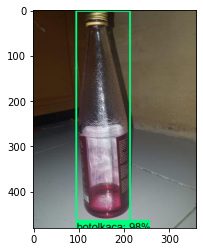

In [87]:
img = cv2.imread(IMAGE_PATH)
image_np = np.array(img)
input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)

detections = detect_fn(input_tensor)

num_detections = int(detections.pop('num_detections'))
detections = {key: value[0, :num_detections].numpy()
                for key, value in detections.items()}
detections['num_detections'] = num_detections

# detection_classes should be ints.
detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

label_id_offset = 1
image_np_with_detections = image_np.copy()

val = viz_utils.visualize_boxes_and_labels_on_image_array(
            image_np_with_detections,
            detections['detection_boxes'],
            detections['detection_classes']+label_id_offset,
            detections['detection_scores'],
            category_index,
            use_normalized_coordinates=True,
            max_boxes_to_draw=5,
            min_score_thresh=.5,
            agnostic_mode=False)

plt.imshow(cv2.cvtColor(image_np_with_detections, cv2.COLOR_BGR2RGB)) #comment/uncomment aja
plt.show() #comment/uncomment aja

In [ ]:
# error terus maka numpy nya di save lalu dijalanin di ipynb 5
# plt.imshow(cv2.cvtColor(image_np_with_detections, cv2.COLOR_BGR2RGB))
# plt.show()
# np.save('gambar1', val, )

# 10. Real Time Detections from  Webcam

In [46]:
import cv2
import numpy as np

category_index = label_map_util.create_category_index_from_labelmap(files['LABELMAP'])

In [62]:
cap = cv2.VideoCapture(0)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

while cap.isOpened(): 
    ret, frame = cap.read()
    image_np = np.array(frame)
    
    input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
    detections = detect_fn(input_tensor)
    
    num_detections = int(detections.pop('num_detections'))
    detections = {key: value[0, :num_detections].numpy()
                    for key, value in detections.items()}
    detections['num_detections'] = num_detections

    # detection_classes should be ints.
    detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

    label_id_offset = 1
    image_np_with_detections = image_np.copy()

    viz_utils.visualize_boxes_and_labels_on_image_array(
                image_np_with_detections,
                detections['detection_boxes'],
                detections['detection_classes']+label_id_offset,
                detections['detection_scores'],
                category_index,
                use_normalized_coordinates=True,
                max_boxes_to_draw=10,
                min_score_thresh=.3,
                agnostic_mode=False)

    # print(detections['num_detections'])
    # print(detections['detection_classes'])
    # print()

    cv2.imshow('object detection',  cv2.resize(image_np_with_detections, (800, 600)))
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        cap.release()
        cv2.destroyAllWindows()
        break

# 10. Freezing the Graph

In [48]:
FREEZE_SCRIPT = os.path.join(paths['APIMODEL_PATH'], 'research', 'object_detection', 'exporter_main_v2.py ')

In [49]:
command = "python {} --input_type=encoded_image_string_tensor --pipeline_config_path={} --trained_checkpoint_dir={} --output_directory={}".format(FREEZE_SCRIPT ,files['PIPELINE_CONFIG'], paths['CHECKPOINT_PATH'], paths['OUTPUT_PATH'])

In [50]:
print(command)

python Tensorflow\models\research\object_detection\exporter_main_v2.py  --input_type=encoded_image_string_tensor --pipeline_config_path=Tensorflow\workspace\models\my_ssd_mobnet\pipeline.config --trained_checkpoint_dir=Tensorflow\workspace\models\my_ssd_mobnet --output_directory=Tensorflow\workspace\models\my_ssd_mobnet\export


In [51]:
!{command}

2022-05-28 02:45:32.471556: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX AVX2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-28 02:45:32.966087: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1610 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6
Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.map_fn(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.map_fn(fn, elems))
W0528 02:45:33.588965 11712 deprecation.py:610] From c:\Users\User\anaconda3\lib\site-packages\tensorflow\python\autograph\impl\api.py:458: calling m

# 11. Conversion to TFLite

In [52]:
TFLITE_SCRIPT = os.path.join(paths['APIMODEL_PATH'], 'research', 'object_detection', 'export_tflite_graph_tf2.py ')

In [53]:
command = "python {} --pipeline_config_path={} --trained_checkpoint_dir={} --output_directory={}".format(TFLITE_SCRIPT ,files['PIPELINE_CONFIG'], paths['CHECKPOINT_PATH'], paths['TFLITE_PATH'])

In [54]:
print(command)

python Tensorflow\models\research\object_detection\export_tflite_graph_tf2.py  --pipeline_config_path=Tensorflow\workspace\models\my_ssd_mobnet\pipeline.config --trained_checkpoint_dir=Tensorflow\workspace\models\my_ssd_mobnet --output_directory=Tensorflow\workspace\models\my_ssd_mobnet\tfliteexport


In [55]:
!{command}

2022-05-28 02:46:41.691493: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX AVX2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-28 02:46:42.117853: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1673 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6
2022-05-28 02:46:48.124761: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1673 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6
2022-05-28 02:46:50.056125: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localho

In [56]:
FROZEN_TFLITE_PATH = os.path.join(paths['TFLITE_PATH'], 'saved_model')
TFLITE_MODEL = os.path.join(paths['TFLITE_PATH'], 'saved_model', 'detect.tflite')

In [57]:
command = "tflite_convert \
--saved_model_dir={} \
--output_file={} \
--input_shapes=1,320,320,3 \
--input_arrays=normalized_input_image_tensor \
--output_arrays='TFLite_Detection_PostProcess','TFLite_Detection_PostProcess:1','TFLite_Detection_PostProcess:2','TFLite_Detection_PostProcess:3' \
--inference_type=FLOAT \
--quantize_weights=true \
--allow_custom_ops".format(FROZEN_TFLITE_PATH, TFLITE_MODEL, )

In [58]:
print(command)

tflite_convert --saved_model_dir=Tensorflow\workspace\models\my_ssd_mobnet\tfliteexport\saved_model --output_file=Tensorflow\workspace\models\my_ssd_mobnet\tfliteexport\saved_model\detect.tflite --input_shapes=1,320,320,3 --input_arrays=normalized_input_image_tensor --output_arrays='TFLite_Detection_PostProcess','TFLite_Detection_PostProcess:1','TFLite_Detection_PostProcess:2','TFLite_Detection_PostProcess:3' --inference_type=FLOAT --quantize_weights=true --allow_custom_ops


In [59]:
!{command}

Estimated count of arithmetic ops: 1.727 G  ops, equivalently 0.863 G  MACs


2022-05-28 02:47:38.647375: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX AVX2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-28 02:47:39.049680: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1673 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6
2022-05-28 02:48:18.499002: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:357] Ignored output_format.
2022-05-28 02:48:18.499194: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:360] Ignored drop_control_dependency.
2022-05-28 02:48:18.500467: I tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: Tensorflow\workspace\models\my_s